In [32]:
import numpy as np
import keras
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import scipy.io
import cv2
import os

In [2]:
HANDS_DATASET = '../data/original/hand_dataset'

IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test_dataset/test_data')
IMAGE_VALIDATION_DIR = os.path.join(HANDS_DATASET, 'validation_dataset/validation_data')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training_dataset/training_data')

IMAGE_SHAPE=(200, 200, 3)

In [3]:
conv_base = load_model('../data/models/2018-10-09 20:54:49___0.940677957009461.h5')

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [5]:
# Create new model
# Get input
new_input = conv_base.input
# Find the layer to connect
hidden_layer = conv_base.layers[-2].output
# Connect a new layer on it
new_output = Dense(2) (hidden_layer)
# Build a new model
model = Model(new_input, new_output)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
__________

## TODO:

- Load all annotations
- Create histogram/table of how how many hands are typically in an image
- Take only a subset of the hands
- Draw the square around image
- Make sure they line up

In [7]:
def load_annotations(file):
    f = scipy.io.loadmat(file)
    #print(f.keys())
    #print(f['boxes'])
    #print(f)
    data = f.get('boxes')
    data = np.array(data)
    
    # We only want the rectangular points from each annotation
    image_annotations = []
    for hand in data[0]:
        # I'm not entirely sure why, but the shape of each file seems to be wrapped in a lot of empty lists
        polygon_points = hand[0][0]
        # We only want the first four items (that actually make up the polygon)
        polygon_points = list(polygon_points)[:4]
        # Again, each point has an empty list wrapped around
        polygon_points = [point[0] for point in polygon_points]
        # points are actually reversed, we want them to be [x, y], but matlab really likes them as [y, x]
        image_annotations.append([[point[1], point[0]] for point in polygon_points])
        

    return image_annotations

len(load_annotations('/Users/kjprice/Library/Projects/smu/capstone/data/original/hand_dataset/validation_dataset/validation_data/annotations/Movie_4weds_1.mat'))


5

In [8]:
b = load_img('../data/original/hand_dataset/training_dataset/training_data/images/Buffy_1.jpg')
b = img_to_array(b)
b.shape

(707, 618, 3)

In [44]:
def load_annotations_from_dir(directory):
    annotations_dir = os.path.join(directory, 'annotations')
    annotation_files = os.listdir(annotations_dir)
    annotations_for_all_files = []
    for annotation_file in annotation_files:
        # ignore config files
        if annotation_file.find('.') == 0:
            continue
        matlab_filepath = os.path.join(annotations_dir, annotation_file)
        annotations = load_annotations(matlab_filepath)
        annotations_for_all_files.append(annotations)
        break
    return annotations_for_all_files

def load_images_from_dir(directory):    
    images_dir = os.path.join(directory, 'images')
    images = os.listdir(images_dir)

    imgs = [] # TODO: Delete

    for _file in images:
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        img_ORIGINAL = load_img(filepath)
        #imgs.append(img_ORIGINAL)
        imgs.append(img_to_array(img_ORIGINAL))
        break
        
    return imgs

In [79]:
def resize_images_and_annotations(images, annotations):
    if len(images) != len(annotations):
        raise Exception('Length of images {} does not match length of annotations'.format(images, annotations))
    
    # TODO:
    # - loop through each item
    # - determine how much we will need to change the image for it to be in size `IMAGE_SHAPE`
    # - the same variation that the image was changed, also change the annotations
    
    x_dataset = np.ndarray(shape=((len(images),) + IMAGE_SHAPE),
                     dtype=np.float32)

    i = 0
    imgs = []
    for (image, annotation) in zip(images, annotations):
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        original_width, original_height, original_depth = image.shape
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        new_width, new_height, new_depth = resized_image.shape
        width_change = new_width / original_width
        height_change = new_height / original_height
        print(original_width, width, width_change)
        print(original_height, new_height, height_change)
        
        # now resize the annotations
        
        imgs.append(resized_image)

        
        i += 1
        break
        if i % 250 == 0:
            print("%d images to array" % i)
    return (images, annotations)
            
def load_images_as_np(directory):
    
    input_shape = (IMAGE_SHAPE[2], IMAGE_SHAPE[1], IMAGE_SHAPE[0])

    images_original = load_images_from_dir(directory)
    annotations_original = load_annotations_from_dir(directory)
    
    x_dataset, y_dataset = resize_images_and_annotations(images_original, annotations_original)


            
    return x_dataset, y_dataset
x, y = load_images_as_np(IMAGE_TRAIN_DIR)

707 200 0.2828854314002829
618 200 0.32362459546925565


In [80]:
image = x[0]


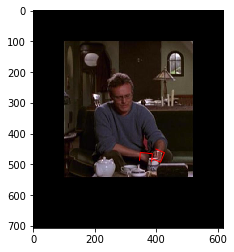

In [81]:
def display_image_with_annotations(img, annotations):
    plt.imshow(array_to_img(img))
    b = plt.gca()
    for annotation in annotations:
        line = plt.Polygon(annotation, closed=None, fill=None, edgecolor='r')
        b.add_patch(line)

first_annotations_from_first_video = y[0]
first_image = x[0]
display_image_with_annotations(first_image, first_annotations_from_first_video)

In [ ]:
def create_data_generator():
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(
            # This is the target directory
            IMAGE_TRAIN_DIR,
            batch_size=20,)

    validation_generator = validation_datagen.flow(
            IMAGE_VALIDATION_DIR,
            batch_size=20,)
    
    return [train_generator, validation_generator]

create_data_generator()